<a href="https://colab.research.google.com/github/MarkLimmage/GrapheneOxideClustering/blob/main/Object_Recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognising Objects in Sea Floor Images

First the training images need to be collated into a single folder

In [3]:
# Load some libraries
import os
import shutil
import pandas as pd
from tqdm import tqdm # progress bar
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [4]:

def get_filepaths(directory):

    file_names = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for dir, directories, files in os.walk(directory, topdown=False):
        for file in files:
          path = os.path.join( dir, file)
          file_names.append(path)  # Add it to the list.
          
    return file_names

# Run the above function and store its results in a variable.
full_names = get_filepaths("/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/BB")



dict = {'path': full_names}
df = pd.DataFrame(dict)

# saving the dataframe
# df.to_csv('/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/test.csv')

# now copy the files into a single folder


def copy_files():
    root = "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/BB"
    for index, row in df.iterrows():
      try:
        if( (row['path'].split("/")[10] != '.DS_Store') & (row['path'].split("/")[10] != '.ipynb_checkpoints') ) :
          file_name = row['path'].split("/")[10]
          new_path = os.path.join( "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/train", file_name)
          old_path = row['path']
          shutil.copy(old_path,new_path)
      except:
        print('ouch')

#copy_files()

drop_list = []
for index, row in df.iterrows():
  if( row['path'][-10:] == '/.DS_Store'):
    drop_list.append( index )
    
df = df.drop(drop_list)
df


path
1    /content/drive/MyDrive/Colab Notebooks/MA5854_...
2    /content/drive/MyDrive/Colab Notebooks/MA5854_...
3    /content/drive/MyDrive/Colab Notebooks/MA5854_...
4    /content/drive/MyDrive/Colab Notebooks/MA5854_...
5    /content/drive/MyDrive/Colab Notebooks/MA5854_...
..                                                 ...
186  /content/drive/MyDrive/Colab Notebooks/MA5854_...
187  /content/drive/MyDrive/Colab Notebooks/MA5854_...
189  /content/drive/MyDrive/Colab Notebooks/MA5854_...
190  /content/drive/MyDrive/Colab Notebooks/MA5854_...
191  /content/drive/MyDrive/Colab Notebooks/MA5854_...

[184 rows x 1 columns]

In [5]:
# Set some variables
%cd /content

ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV"
IMAGE_DIR = "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/train"  # directory to save images
LABEL_DIR = "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/labels"  # directory to save labels

FOLD = 0  # which fold to train
DIM = 640
MODEL = "yolov5x"
BATCH = 16
EPOCHS = 15
OPTMIZER = "SGD"
WIDTH = 4096
HEIGHT = 2304

PROJECT = "object-identification"  # w&b in yolov5
NAME = f"{MODEL}-dim{DIM}-fold{FOLD}"  # w&b for yolov5




/content


## Construct a training dataset df
File names will correspond to the names in the labelling files. Images were labelled using https://www.makesense.ai/. Label outputs were downloaded in VOC xml, YOLO txt and csv formats. These have been saved into the labels fodler in inputs. 



In [6]:
# Train Data
df2 = pd.read_csv(f"{ROOT_DIR}/input/labels/labels.csv", names=['labels','x_corner', 'y_corner','ob_width','ob_height', 'file','im_width','im_height' ] )
df2["label_path"] = f"{LABEL_DIR}/YOLO_TXT/" + df2.file.str.replace("jpg", "txt")
df2["image_path"] = f"{IMAGE_DIR}/" + df2.file
df2.head(5)

labels  x_corner  y_corner  ob_width  ob_height  \
0    metal_bar      1968       841        98         73   
1  misc_object      2367      1445       111         62   
2  misc_object      2365      1046        97         47   
3  misc_object      2267      1053        87         62   
4  misc_object      2088      1217        81         63   

                                       file  im_width  im_height  \
0  image_D2022-01-24T00-03-30-143223Z_1.jpg      4096       2304   
1  image_D2022-01-24T00-03-30-143223Z_1.jpg      4096       2304   
2  image_D2022-01-24T00-03-30-143223Z_1.jpg      4096       2304   
3  image_D2022-01-24T00-03-30-143223Z_1.jpg      4096       2304   
4  image_D2022-01-24T00-03-30-143223Z_1.jpg      4096       2304   

                                          label_path  \
0  /content/drive/MyDrive/Colab Notebooks/MA5854_...   
1  /content/drive/MyDrive/Colab Notebooks/MA5854_...   
2  /content/drive/MyDrive/Colab Notebooks/MA5854_...   
3  /content/drive/MyDrive/Colab Notebooks/MA5854_...   
4  /content/drive/MyDrive/Colab Notebooks/MA5854_...   

                                          image_path  
0  /content/drive/MyDrive/Colab Notebooks/MA5854_...  
1  /content/drive/MyDrive/Colab Notebooks/MA5854_...  
2  /content/drive/MyDrive/Colab Notebooks/MA5854_...  
3  /content/drive/MyDrive/Colab Notebooks/MA5854_...  
4  /content/drive/MyDrive/Colab Notebooks/MA5854_...

# Explore the data
Take a look at the distribution of classes.

There are 184 images, 648 objects and 26 classes.


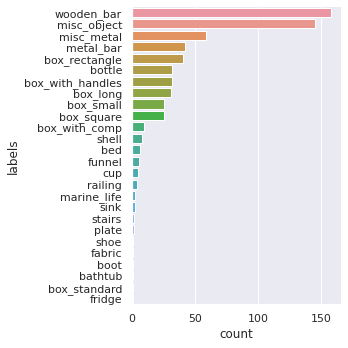

In [7]:
# Get the labels

classes = df2.labels.unique()

print('There are ' + str(len(df)) + ' images, ' + str(len(df2)) + " objects and " + str(len(classes)) + ' classes.')

sns.set_theme(style="darkgrid")
ax1 = sns.catplot(y="labels", 
                  data=df2, kind="count", 
                  order = df2['labels'].value_counts().index )




## Augmenting training data
Ideally the training data set should be augmented such that the distribution of classes is uniform. The strategy will be based on the following considerations.

1.   Create the training dataset by copying images and labels into the train folders. 
2.   To create a more uniform class distribution, use augmentation to increase the number of images containing particular objects.
3.   Move 15% of training images and labels to the validation folders.

Since many of the images contain multiple different objects classes, without careful selection of images to augment, the resulting class distribution will not be perfectly uniform. Initially, this won't be considered, but the distribution can be checked following the process.
 



In [8]:
aug_reqs = {
    "count":df2['labels'].value_counts(), 
    "factor": max(df2['labels'].value_counts())/df2['labels'].value_counts()}
aug_reqs = pd.DataFrame(aug_reqs)
aug_reqs['factor'] = round(aug_reqs['factor'])-1
aug_reqs

count  factor
wooden_bar          158     0.0
misc_object         145     0.0
misc_metal           59     2.0
metal_bar            42     3.0
box_rectangle        41     3.0
bottle               32     4.0
box_with_handles     32     4.0
box_long             31     4.0
box_small            26     5.0
box_square           26     5.0
box_with_comp        10    15.0
shell                 8    19.0
bed                   7    22.0
funnel                6    25.0
cup                   5    31.0
railing               4    39.0
marine_life           3    52.0
sink                  3    52.0
stairs                2    78.0
plate                 2    78.0
shoe                  1   157.0
fabric                1   157.0
boot                  1   157.0
bathtub               1   157.0
box_standard          1   157.0
fridge                1   157.0

## Use Albumentations
Albumentations allows for control over image augmentation

In [9]:
# Install required libraries
# !pip install -U git+https://github.com/albumentations-team/albumentations
!pip install -U albumentations --no-binary qudida,albumentations # uses the installed versino of opencv

# To install the required version of opencv
#!pip uninstall opencv-python-headless==4.5.5.64
#!pip install opencv-python-headless==4.5.2.52



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 178 kB 4.9 MB/s 
Skipping wheel build for albumentations, due to binaries being disabled for it.
Skipping wheel build for qudida, due to binaries being disabled for it.
    Running setup.py install for qudida ... done
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
    Running setup.py install for albumentations ... done


In [10]:
import albumentations as A
import cv2

In [11]:
yolo_labels = get_filepaths("/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/labels/YOLO_TXT")
yolo_labels = pd.DataFrame(yolo_labels, columns=['file'])
label_df = pd.DataFrame(columns=['file','class','x_center','y_center','width','height'])
for index, file in tqdm(yolo_labels.iterrows()):
  y_file = pd.read_csv(file.file, sep=" ", header=None, names=['class','x_center','y_center','width','height'])
  y_file['file'] = file.file.split("/")[9].split(".")[0]+'.jpg'
  label_df = label_df.append(y_file)

label_df['px_width'] = label_df['width'].apply(lambda x: x * 4096 )
label_df['px_height'] = label_df['height'].apply(lambda y: y * 2304 )
label_df['x_corner'] = label_df['x_center'].apply(lambda x: x * 4096 ) - label_df['px_width'].apply(lambda x: x * 0.5 )
label_df['y_corner'] = label_df['y_center'].apply(lambda y: y * 2304 ) - label_df['px_height'].apply(lambda x: x * 0.5 )

# Now match the yolo int labels with class names from the csv
class_names = pd.DataFrame()
for index, row in label_df.iterrows():
  names = df2[
      (df2['file'] == row['file'] ) &
      (abs(df2['x_corner'] - row['x_corner']) < 3)
      ]['labels']
  for labels in names.iteritems():
    class_names=class_names.append( {'label':labels[1], 'class':row['class'] }, ignore_index=True )

object_dict = class_names.drop_duplicates().sort_values('class')

object_dict


184it [00:01, 99.76it/s] 


label  class
4           metal_bar    0.0
11         wooden_bar    1.0
3          misc_metal    2.0
9         misc_object    3.0
5              bottle    4.0
293           bathtub    5.0
16      box_with_comp    6.0
22   box_with_handles    7.0
8            box_long    8.0
17         box_square    9.0
0       box_rectangle   10.0
13          box_small   11.0
281      box_standard   12.0
55                cup   14.0
550            fridge   15.0
232             shell   16.0
132              sink   17.0
436             plate   18.0
2                 bed   19.0
163            fabric   20.0
61        marine_life   21.0
1              funnel   23.0
603              shoe   24.0
134           railing   25.0
125              boot   26.0
236            stairs   27.0

There are a few missing label indicies eg 22 and 13 so need to create a dictionary that has these.

In [12]:
n=len(object_dict)
names={}
m = int(max(object_dict['class']))
for i in range(0,m+1):
  try:
    names[i] = object_dict.loc[(object_dict['class'] == float(i), 'label')].iloc[0]
  except:
    names[i] = 'na'
  
names 



{0: 'metal_bar',
 1: 'wooden_bar',
 2: 'misc_metal',
 3: 'misc_object',
 4: 'bottle',
 5: 'bathtub',
 6: 'box_with_comp',
 7: 'box_with_handles',
 8: 'box_long',
 9: 'box_square',
 10: 'box_rectangle',
 11: 'box_small',
 12: 'box_standard',
 13: 'na',
 14: 'cup',
 15: 'fridge',
 16: 'shell',
 17: 'sink',
 18: 'plate',
 19: 'bed',
 20: 'fabric',
 21: 'marine_life',
 22: 'na',
 23: 'funnel',
 24: 'shoe',
 25: 'railing',
 26: 'boot',
 27: 'stairs'}

In [13]:
# Create some helper function

transform = A.Compose([
    A.Affine(scale=1, 
             translate_px={'x':[10,100], 'y':[10,50]}, 
             rotate=None, 
             shear=None, 
             interpolation=1, 
             mask_interpolation=0, 
             cval=0, 
             cval_mask=0, 
             mode=0, 
             fit_output=False, 
             always_apply=True, p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),], 
    bbox_params=A.BboxParams(
        format='yolo', 
        min_area=0.0, 
        min_visibility=0.5,
        label_fields=['class_labels']
         )
    )

def apply_augmentation(image, bboxes, class_labels):
  transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
  return transformed



In [183]:
names.values()

dict_values(['metal_bar', 'wooden_bar', 'misc_metal', 'misc_object', 'bottle', 'bathtub', 'box_with_comp', 'box_with_handles', 'box_long', 'box_square', 'box_rectangle', 'box_small', 'box_standard', 'na', 'cup', 'fridge', 'shell', 'sink', 'plate', 'bed', 'fabric', 'marine_life', 'na', 'funnel', 'shoe', 'railing', 'boot', 'stairs'])

In [181]:


import yaml

data = [{    
    'train': 'train/images',
    'val': 'valid/images',
    'nc': 28,
    'names': list(names.values()),
    'path': '../datasets/',
    }]

with open('data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

In [46]:
# Remove existing directories if necessary
%rm -r "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/aug/images"
%rm -r "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/aug/labels"

In [47]:

%mkdir "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/aug/images/"
%mkdir "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/aug/labels/"

In [21]:

#objects = pd.DataFrame( columns=['object','file', 'ob_count', 'other_obs'])
for label, factor in tqdm(aug_reqs.iterrows(), ):
    objects = pd.DataFrame( columns=['object','file', 'ob_count', 'other_obs'])
    #if(label=='wooden_bar'): # To do just a single object
      # Copy the original training images and their labels to the datasets folders
      files = df2.loc[df2['labels'] == label]['file']
      n=0
      print(label + ' ' + str(len(files)) + ' files.')
      for file in files:
        train_file = file.split(".")[0] + ".txt"
        old_image_path = os.path.join( "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/train", file)
        old_label_path = os.path.join( "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/input/labels/YOLO_TXT", train_file)
        train_image_path = os.path.join( "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/aug/images", file)
        train_label_path = os.path.join( "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/aug/labels", train_file)
        shutil.copy(old_image_path,train_image_path)
        shutil.copy(old_label_path,train_label_path)      
        n=n+1

      # Get a list of the files containing the object, the number of occurances of 
      # the object in the image and the number of other objects in each image.
      files = df2.loc[df2['labels'] == label]['file'].unique()
      for file in files:
        count = len(df2[(df2['file'] == file) & (df2['labels'] == label)])
        other_obs = len(df2[(df2['file'] == file) & (df2['labels'] != label)])
        objects = objects.append({'object':label,'file':file,'ob_count':count, 'other_obs':other_obs}, ignore_index=True)
      
      # Iterate through the files containing less than 2 other objects and copy
      # augmentations of those images and their labels to the datasets folders
      # until number of objects in the datasets > target
      filtered_objects = objects[objects['other_obs'] < 20 ]
      target = 158
      while n < target:
        for index, row in filtered_objects.iterrows():
          n = n + row['ob_count']
          if(n > target):
            break
          name = row['file'].split(".")[0]
          file_path = os.path.join( "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/aug/images", name +".jpg")
          bboxes = os.path.join( "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/aug/labels", name +".txt")
          # Augment the image and its label
          image = cv2.imread(file_path)
          boxes = pd.read_csv(bboxes, sep=' ', header=None )
          bboxes = boxes.loc[:,1:4].to_numpy()
          class_labels = list(boxes[0].tolist())
          
          # Add labels to the bboxes
          # apply_augmentation
        
          transformed = apply_augmentation(image , bboxes, class_labels)
          labels = pd.DataFrame(transformed['bboxes']) 
          classes = pd.DataFrame(transformed['class_labels'])
          labels.insert(0, '', classes )
          np.savetxt( os.path.join( "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/aug/labels", name + "_aug_" + str(n) + ".txt"), labels )
          cv2.imwrite( os.path.join( "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/aug/images", name + "_aug_" + str(n) + ".jpg"), transformed['image'] )





0it [00:00, ?it/s]

wooden_bar 158 files.


26it [00:12,  2.00it/s]


Now check to see how these augmentatinos have affected the class distribution

In [56]:
# Remove previous local training set if required 
%rm -r /content/datasets/train/images
%rm -r /content/datasets/train/labels

In [1]:
# make the local data set dir structure

!mkdir -p datasets
!mkdir -p datasets/train
!mkdir -p datasets/train/images
!mkdir -p datasets/train/labels
!mkdir -p datasets/valid
!mkdir -p datasets/valid/images
!mkdir -p datasets/valid/labels

In [2]:
# Copy the images and labels into the instance storage
%cp -r "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/aug/images/" "/content/datasets/train/"
%cp -r "/content/drive/MyDrive/Colab Notebooks/MA5854_AUV/aug/labels/" "/content/datasets/train/"

In [15]:
full_names = get_filepaths("/content/datasets/train/images")

dict = {'path': full_names}
df = pd.DataFrame(dict)

df


path
0     /content/datasets/train/images/image_D2022-01-...
1     /content/datasets/train/images/image_D2022-01-...
2     /content/datasets/train/images/image_D2022-01-...
3     /content/datasets/train/images/image_D2022-01-...
4     /content/datasets/train/images/image_D2022-01-...
...                                                 ...
2853  /content/datasets/train/images/image_D2022-01-...
2854  /content/datasets/train/images/image_D2022-01-...
2855  /content/datasets/train/images/image_D2022-01-...
2856  /content/datasets/train/images/image_D2022-01-...
2857  /content/datasets/train/images/image_D2022-01-...

[2858 rows x 1 columns]

In [16]:
names

{0: 'metal_bar',
 1: 'wooden_bar',
 2: 'misc_metal',
 3: 'misc_object',
 4: 'bottle',
 5: 'bathtub',
 6: 'box_with_comp',
 7: 'box_with_handles',
 8: 'box_long',
 9: 'box_square',
 10: 'box_rectangle',
 11: 'box_small',
 12: 'box_standard',
 13: 'na',
 14: 'cup',
 15: 'fridge',
 16: 'shell',
 17: 'sink',
 18: 'plate',
 19: 'bed',
 20: 'fabric',
 21: 'marine_life',
 22: 'na',
 23: 'funnel',
 24: 'shoe',
 25: 'railing',
 26: 'boot',
 27: 'stairs'}

In [85]:
yolo_labels = get_filepaths("/content/datasets/train/labels")
yolo_labels = pd.DataFrame(yolo_labels, columns=['file'])
label_df = pd.DataFrame(columns=['file','class','x_center','y_center','width','height'])
for index, file in tqdm(yolo_labels.iterrows()):
  y_file = pd.read_csv(file.file, sep=" ", header=None, names=['class','x_center','y_center','width','height'])
  y_file['file'] = file.file.split(".")[0]+'.txt'
  label_df = label_df.append(y_file)

label_df['px_width'] = label_df['width'].apply(lambda x: x * 4096 )
label_df['px_height'] = label_df['height'].apply(lambda y: y * 2304 )
label_df['x_corner'] = label_df['x_center'].apply(lambda x: x * 4096 ) - label_df['px_width'].apply(lambda x: x * 0.5 )
label_df['y_corner'] = label_df['y_center'].apply(lambda y: y * 2304 ) - label_df['px_height'].apply(lambda x: x * 0.5 )

label_df


2858it [00:09, 295.56it/s]


file  class  x_center  \
0   /content/datasets/train/labels/image_D2022-01-...   17.0  0.303305   
0   /content/datasets/train/labels/image_D2022-01-...   18.0  0.737035   
1   /content/datasets/train/labels/image_D2022-01-...   18.0  0.279243   
2   /content/datasets/train/labels/image_D2022-01-...    7.0  0.308464   
3   /content/datasets/train/labels/image_D2022-01-...    1.0  0.778026   
..                                                ...    ...       ...   
5   /content/datasets/train/labels/image_D2022-01-...    3.0  0.053768   
6   /content/datasets/train/labels/image_D2022-01-...    3.0  0.544434   
0   /content/datasets/train/labels/image_D2022-01-...   15.0  0.413276   
1   /content/datasets/train/labels/image_D2022-01-...   23.0  0.828455   
2   /content/datasets/train/labels/image_D2022-01-...   10.0  0.396231   

    y_center     width    height    px_width   px_height     x_corner  \
0   0.351185  0.076299  0.116883  312.520704  269.298432  1086.076672   
0   0.470379  0.056006  0.116883  229.400576  269.298432  2904.194752   
1   0.523770  0.031656  0.059163  129.662976  136.311552  1078.947520   
2   0.235170  0.080357  0.125541  329.142272  289.246464  1098.897088   
3   0.669513  0.051948  0.223665  212.779008  515.324160  3080.404672   
..       ...       ...       ...         ...         ...          ...   
5   0.685961  0.081168  0.111111  332.464128  255.999744    54.000000   
6   0.008565  0.021916  0.017130   89.767936   39.468608  2185.116032   
0   0.359425  0.173701  0.277056  711.479296  638.337024  1337.039360   
1   0.076538  0.231331  0.153077  947.531776  352.689088  2919.586304   
2   0.504447  0.113636  0.189033  465.453056  435.532032  1390.236160   

        y_corner  
0   6.744810e+02  
0   9.491041e+02  
1   1.138610e+03  
2   3.972085e+02  
3   1.284896e+03  
..           ...  
5   1.452454e+03  
6   0.000000e+00  
0   5.089475e+02  
1  -5.684342e-14  
2   9.444807e+02  

[12312 rows x 10 columns]

In [86]:
new_label_df = pd.merge(label_df, 
                      object_dict, 
                      on ='class', 
                      how ='left')

new_label_df

file  class  x_center  \
0      /content/datasets/train/labels/image_D2022-01-...   17.0  0.303305   
1      /content/datasets/train/labels/image_D2022-01-...   18.0  0.737035   
2      /content/datasets/train/labels/image_D2022-01-...   18.0  0.279243   
3      /content/datasets/train/labels/image_D2022-01-...    7.0  0.308464   
4      /content/datasets/train/labels/image_D2022-01-...    1.0  0.778026   
...                                                  ...    ...       ...   
12307  /content/datasets/train/labels/image_D2022-01-...    3.0  0.053768   
12308  /content/datasets/train/labels/image_D2022-01-...    3.0  0.544434   
12309  /content/datasets/train/labels/image_D2022-01-...   15.0  0.413276   
12310  /content/datasets/train/labels/image_D2022-01-...   23.0  0.828455   
12311  /content/datasets/train/labels/image_D2022-01-...   10.0  0.396231   

       y_center     width  ...    px_width   px_height     x_corner  \
0      0.351185  0.076299  ...  312.520704  269.298432  1086.076672   
1      0.470379  0.056006  ...  229.400576  269.298432  2904.194752   
2      0.523770  0.031656  ...  129.662976  136.311552  1078.947520   
3      0.235170  0.080357  ...  329.142272  289.246464  1098.897088   
4      0.669513  0.051948  ...  212.779008  515.324160  3080.404672   
...         ...       ...  ...         ...         ...          ...   
12307  0.685961  0.081168  ...  332.464128  255.999744    54.000000   
12308  0.008565  0.021916  ...   89.767936   39.468608  2185.116032   
12309  0.359425  0.173701  ...  711.479296  638.337024  1337.039360   
12310  0.076538  0.231331  ...  947.531776  352.689088  2919.586304   
12311  0.504447  0.113636  ...  465.453056  435.532032  1390.236160   

           y_corner             label  
0      6.744810e+02              sink  
1      9.491041e+02             plate  
2      1.138610e+03             plate  
3      3.972085e+02  box_with_handles  
4      1.284896e+03        wooden_bar  
...             ...               ...  
12307  1.452454e+03       misc_object  
12308  0.000000e+00       misc_object  
12309  5.089475e+02            fridge  
12310 -5.684342e-14            funnel  
12311  9.444807e+02     box_rectangle  

[12312 rows x 11 columns]

## Take a look at the new distribution
There is still a lot more misc_objects, wooden_bars and misc_metal objects than any of the other categories, but there are now at least 158 of every object. 

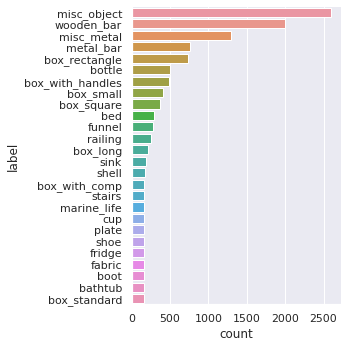

In [87]:
sns.set_theme(style="darkgrid")
ax1 = sns.catplot(y="label", 
                  data=new_label_df, kind="count", 
                  order = new_label_df['label'].value_counts().index )

Define some functions to help visualise the results of augmentations.

In [21]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    w = w*WIDTH
    h = h*HEIGHT
    x_min = x_min * WIDTH - (0.5 * w)
    y_min = y_min * HEIGHT - (0.5 * h)
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(36, 36))
    plt.axis('off')
    plt.imshow(img)

## Visualise augmented image & bounding boxes
Take the last image augmented and visualuise it using the helper functions.

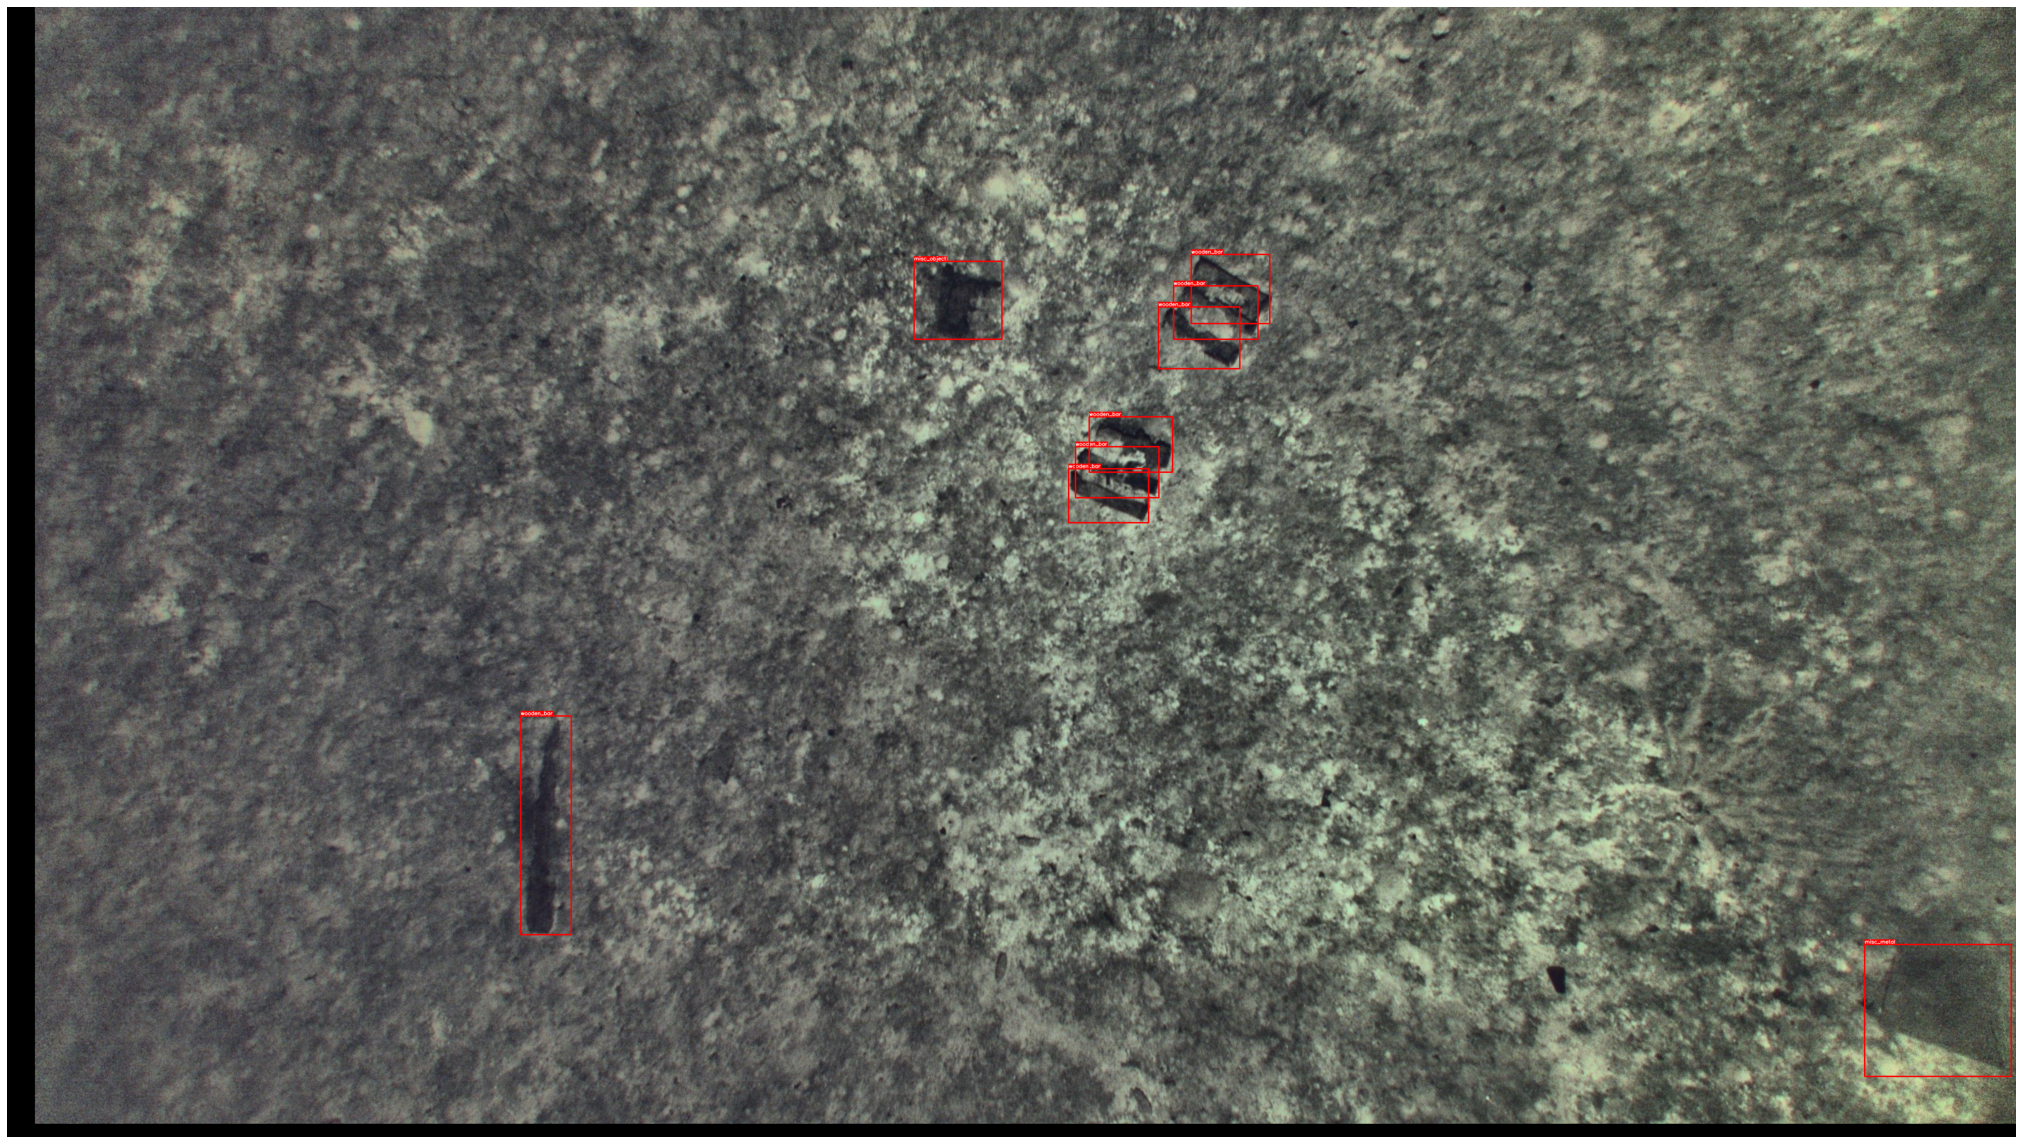

In [30]:
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['class_labels'],
    names
)


## Create the validation set of image / labels

In [122]:
import random
import os

In [144]:
for index, row in object_dict.iterrows():
  n=0
  while n < 15:
    images = new_label_df[new_label_df['label']==row.label]
    ims = pd.DataFrame(images['file'].unique())
    s = ims.sample(n=1)
    for i, r in s.iterrows():
      la_file = r[0].split("/")[5]
      im_file_end = r[0].split("/")[5].split(".")[0]+'.jpg'
      o_im_path = os.path.join( "/content/datasets/train/images", im_file_end)
      n_im_path = os.path.join( "/content/datasets/valid/images", im_file_end)

      o_la_path = os.path.join( "/content/datasets/train/labels", la_file)    
      n_la_path = os.path.join( "/content/datasets/valid/labels", la_file)     
      try:
        shutil.move(o_im_path, n_im_path)   
        shutil.move(o_la_path, n_la_path)
        n=n+1
      except:
        n=n
      



In [136]:
%mv /content/datasets/valid/labels/* /content/datasets/train/labels

# Install YOLOv5

In [ ]:
%cd yolov5

In [158]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
from IPython.display import Image, clear_output
display = utils.notebook_init()  # checks



YOLOv5 🚀 v6.1-233-g7433d38 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 53.6/78.2 GB disk)


In [1]:
!python train.py --batch 32 --epochs 15 --data /content/yolov5/data.yaml --weights yolov5s.pt --cache

python3: can't open file 'train.py': [Errno 2] No such file or directory
